<a href="https://colab.research.google.com/github/FaiAttaallah/Machine-Learning/blob/main/Project_using_MOBILENETV2_(Final_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Upload the Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving ClothesDataset.zip to ClothesDataset.zip


## Import the Libraries

In [ ]:
import os
import shutil
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd


## Unzip and Clean the Dataset


In [ ]:
!unzip -n -q "ClothesDataset.zip" -d /content/

## Clean folders

In [ ]:
!find /content/ClothesDataset -name "__MACOSX" -exec rm -r {} +
!find /content/ClothesDataset -name "._*" -delete
!find /content/ClothesDataset -name ".DS_Store" -delete

## Verify the Dataset

In [ ]:
!ls /content/ClothesDataset/

 Bershka  'H&M'   Next	 Zara


## Convert images to JPG

In [ ]:
!pip install pillow-avif-plugin
from PIL import Image
import os
root = "/content/ClothesDataset/"
count = 0
for brand in os.listdir(root):
   folder = os.path.join(root, brand)
   for fname in os.listdir(folder):
       # Check for AVIF or WEBP
       if fname.lower().endswith((".avif", ".webp")):
           old_path = os.path.join(folder, fname)
           new_path = os.path.splitext(old_path)[0] + ".jpg"  # replace with JPG
           try:
               img = Image.open(old_path).convert("RGB")  # convert to standard RGB
               img.save(new_path, "JPEG", quality=95)
               os.remove(old_path)  # delete old file
               count += 1
               print("Converted:", fname)
           except Exception as e:
               print("Error converting:", fname, e)
print(f"\nDone! Converted {count} images from AVIF/WEBP to JPG.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 39.7 MB/s eta 0:00:00
Converted: IMG_5277.WEBP
Converted: 08606693906-a4o.webp
Converted: 06983686800-a4o.webp
Converted: 05160218700-a4o.webp
Converted: 06650758802-a3o.webp
Converted: 06594534401-a4o.webp
Converted: 01524719122-a4o.webp
Converted: IMG_5271.WEBP
Converted: IMG_5252.WEBP
Converted: IMG_5272.WEBP
Converted: IMG_5260.WEBP
Converted: 06993686802-a4o.webp
Converted: 06989686892-a4o.webp
Converted: IMG_5267.WEBP
Converted: IMG_5258.WEBP
Converted: 06991693712-a4o.webp
Converted: 07130686600-a4o.webp
Converted: 07110681500-a4o.webp
Converted: 07180218700-a4o.webp
Converted: 07104645800-a4o.webp
Converted: 06717551637-a4o.webp
Converted: 06985693902-a2d.webp
Converted: IMG_5278.WEBP
Converted: 06985693902-p.webp
Converted: 05292700611-a4o.webp
Converted: IMG_5261.WEBP
Converted: IMG_5259.WEBP
Converted: IMG_5250.WEBP
Converted: IMG_5263.WEBP
Converted: IMG_5268.WEBP
Converted: IMG_5265.WEBP
Converted: 06543710800-p.webp
C

## Split Dataset into train/val/test

In [ ]:
root = "/content/ClothesDataset/"
base = "/content/split_dataset"

# Remove old split dataset if exists
shutil.rmtree(base, ignore_errors=True)

# Create new structure
for split in ["train", "val", "test"]:
    for cls in os.listdir(root):
        os.makedirs(os.path.join(base, split, cls), exist_ok=True)

# Ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Perform splitting
for cls in os.listdir(root):
    cls_folder = os.path.join(root, cls)
    images = os.listdir(cls_folder)
    random.shuffle(images)

    total = len(images)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    train_imgs = images[:train_end]
    val_imgs = images[train_end:val_end]
    test_imgs = images[val_end:]

    for img in train_imgs:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(base, "train", cls, img))

    for img in val_imgs:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(base, "val", cls, img))

    for img in test_imgs:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(base, "test", cls, img))

In [ ]:
import os
import shutil
import random
import math

root = "/content/ClothesDataset/"
base = "/content/split_dataset"

# Remove old split dataset
shutil.rmtree(base, ignore_errors=True)

# Create folders
for split in ["train", "val", "test"]:
    for cls in os.listdir(root):
        os.makedirs(os.path.join(base, split, cls), exist_ok=True)

# Ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Fixed seed for reproducibility
random.seed(42)

# Split images
for cls in os.listdir(root):
    cls_folder = os.path.join(root, cls)
    images = os.listdir(cls_folder)
    total = len(images)

    # Compute exact counts using rounding
    val_count = max(1, math.floor(total * val_ratio))    # at least 1 image
    test_count = max(1, math.floor(total * test_ratio))  # at least 1 image
    train_count = total - val_count - test_count         # explicit train count

    # Randomly sample validation images
    val_imgs = random.sample(images, val_count)
    remaining = list(set(images) - set(val_imgs))

    # Randomly sample test images
    test_imgs = random.sample(remaining, test_count)

    # Remaining images go to train
    train_imgs = list(set(remaining) - set(test_imgs))

    # Copy images to folders
    for img in train_imgs:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(base, "train", cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(base, "val", cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(cls_folder, img), os.path.join(base, "test", cls, img))


## Create Keras Generators



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Flow from directories
train_gen = train_datagen.flow_from_directory(
    "/content/split_dataset/train",  # path to train folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    "/content/split_dataset/val",    # path to val folder
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
   "/content/split_dataset/test",
   target_size=(224, 224),
   batch_size=32,
   class_mode="categorical",
   shuffle=False
)


Found 171 images belonging to 4 classes.
Found 46 images belonging to 4 classes.
Found 37 images belonging to 4 classes.


Displaying training set images:


/tmp/ipython-input-1444941067.py:16: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


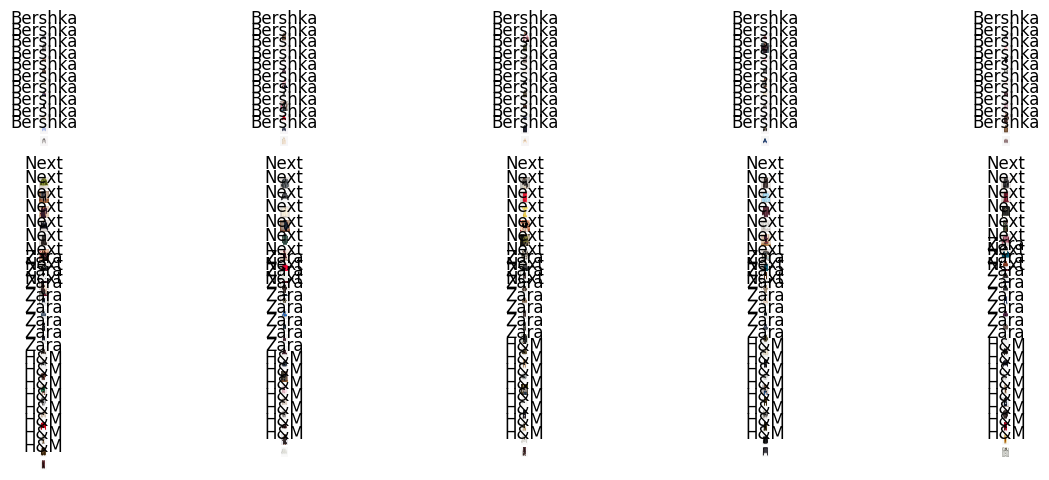

In [ ]:
def display_images_in_grid(directory, num_columns=5):
    plt.figure(figsize=(num_columns * 3, 15))
    i = 1
    for brand in os.listdir(directory):
        brand_path = os.path.join(directory, brand)
        if os.path.isdir(brand_path):
            for fname in os.listdir(brand_path):
                img_path = os.path.join(brand_path, fname)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                    img = Image.open(img_path)
                    plt.subplot(len(os.listdir(directory)) * (len(os.listdir(brand_path)) // num_columns + 1), num_columns, i)
                    plt.imshow(img)
                    plt.title(brand)
                    plt.axis('off')
                    i += 1
    plt.tight_layout()
    plt.show()

print("Displaying training set images:")
display_images_in_grid("/content/split_dataset/train", num_columns=5)




Displaying validation set images:


/tmp/ipython-input-1444941067.py:16: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


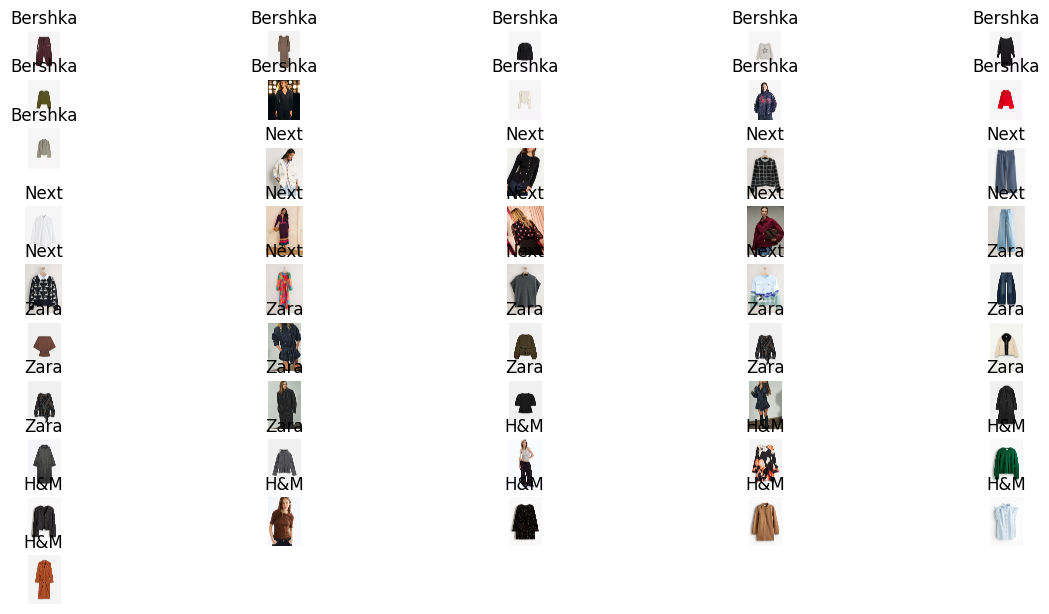

In [ ]:
print("\nDisplaying validation set images:")
display_images_in_grid("/content/split_dataset/val", num_columns=5)


Displaying test set images:


/tmp/ipython-input-1444941067.py:16: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


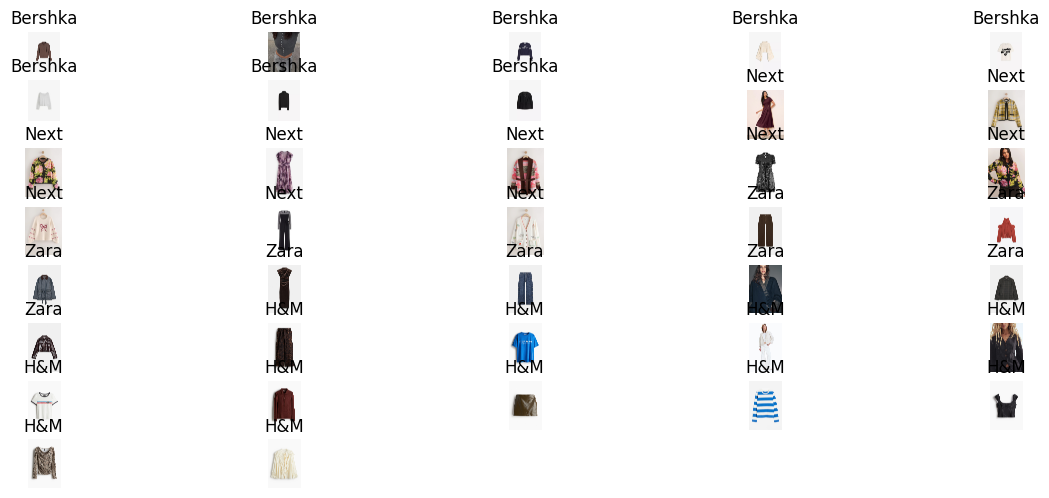

In [ ]:
print("\nDisplaying test set images:")
display_images_in_grid("/content/split_dataset/test", num_columns=5)

## Build a transfer learning model

In [ ]:
base = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3))
base.trainable = False
model = Sequential([
    base,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(train_gen.num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## Training

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
   monitor="val_loss",
   patience=3,
   restore_best_weights=True
)
history = model.fit(
   train_gen,
   epochs=12,
   validation_data=val_gen,
   callbacks=[early_stop]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 31s 4s/step - accuracy: 0.3062 - loss: 1.6027 - val_accuracy: 0.3913 - val_loss: 1.2591
Epoch 2/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.4656 - loss: 1.2171 - val_accuracy: 0.4783 - val_loss: 1.2388
Epoch 3/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5738 - loss: 0.9653 - val_accuracy: 0.4783 - val_loss: 1.1681
Epoch 4/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.6748 - loss: 0.8056 - val_accuracy: 0.5652 - val_loss: 0.9755
Epoch 5/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7116 - loss: 0.7158 - val_accuracy: 0.6087 - val_loss: 0.9466
Epoch 6/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.8009 - loss: 0.5918 - val_accuracy: 0.5652 - val_loss: 0.9063
Epoch 7/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7819 - loss: 0.5468 - val_accuracy: 0.6304 - val_loss: 0.9496
Epoch 8/12
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.7936 - loss: 0.4977 - val_accuracy: 0.6522 - val_loss: 0.8629
Epoch 9/

## Test Set Evaluation

In [ ]:
print("\nTest Set Evaluation:")
model.evaluate(test_gen)


Test Set Evaluation:
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.7753 - loss: 0.8236


[0.8416876792907715, 0.7567567825317383]

## Test:

Saving Image (53).jfif to Image (53) (1).jfif
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step

Predicted Brand: Next
Confidence: 81.75 %


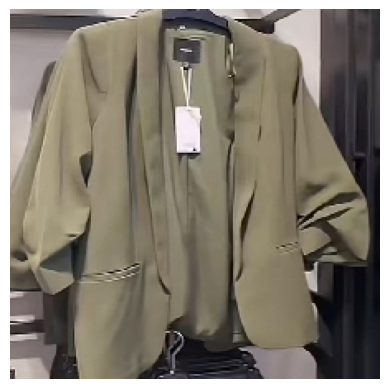

In [ ]:
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

uploaded = files.upload()

for fn in uploaded.keys():
    img = tf.keras.utils.load_img(fn, target_size=(224,224))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    class_index = np.argmax(prediction)
    label_list = list(train_gen.class_indices.keys())

    print("\nPredicted Brand:", label_list[class_index])
    print("Confidence:", round(np.max(prediction)*100, 2), "%")

    plt.imshow(img)
    plt.axis("off")
    plt.show()

Exporting the model to use with the interface:

In [25]:
tf.keras.models.save_model(model, 'tfjs_model.keras')